# Language-Recognition using ConvNets

_written by Joscha S. Rieber (Fraunhofer IAIS) in 2020_

## Training Environment

In [44]:
train = 'train'
test = 'test'

eng = 'english'
ger = 'german'

languages = [eng, ger]
categories = [train, test]

dataset_root_path = '../data/'
train_path = dataset_root_path + train

batch_size = 128
image_width = 500
image_height = 128

validation_split = 0.1
learning_rate = 0.05

num_classes = len(languages)

model_file = dataset_root_path + 'model.h5'

In [45]:
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# XLA compiles your TensorFlow graph into a sequence of GPU kernels generated specifically for your model.
# Since these kernels are unique to your program, they can exploit model-specific information for optimization.

# import os
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_cpu_global_jit'

In [46]:
all_files = glob(train_path + '/*/*.png')

num_validation = len(all_files) * validation_split
num_train = len(all_files) - num_validation

validation_steps = int(num_validation / batch_size)
steps_per_epoch = int(num_train / batch_size)

print('Steps per Epoch: ' + str(steps_per_epoch))
print('Validation steps: ' + str(validation_steps))

Steps per Epoch: 247
Validation steps: 27


## Training Batch Generator Function

The following function loads the available images for training, shuffles them and serves them to Keras' training algorithm.

In [47]:
image_data_generator = ImageDataGenerator(rescale=1./255, validation_split=validation_split)
train_generator = image_data_generator.flow_from_directory(train_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale', subset='training')
validation_generator = image_data_generator.flow_from_directory(train_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale', subset='validation')

Found 31680 images belonging to 2 classes.
Found 3520 images belonging to 2 classes.


## Model definition

In [48]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, AveragePooling2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Input, Concatenate, Activation
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD

In [49]:
#from tensorflow.python.keras.layers import Concatenate
#from tensorflow.python.keras.applications.inception_v3 import InceptionV3

#img_input = Input(shape=(128, 500, 1))

#img_conc = Concatenate(axis=3, name='input_concat')([img_input, img_input, img_input])

#model = InceptionV3(input_tensor=img_conc, weights=None, include_top=True, classes=2)

#model.summary()

In [50]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(image_height, image_width, 1)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 500, 16)      160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 250, 16)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 250, 32)       4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 125, 32)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 125, 64)       18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 62, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 62, 128)      

In [51]:
model.compile(optimizer=SGD(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

## Training

In [52]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True)

In [53]:
model.fit(train_generator, validation_data=validation_generator, epochs=60, steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, callbacks=[early_stopping])

Epoch 1/60
247/247 [==============================] - 138s 559ms/step - loss: 0.6556 - accuracy: 0.6129 - val_loss: 0.6979 - val_accuracy: 0.5425
Epoch 2/60
247/247 [==============================] - 70s 284ms/step - loss: 0.5736 - accuracy: 0.6992 - val_loss: 0.7087 - val_accuracy: 0.5859
Epoch 3/60
247/247 [==============================] - 65s 262ms/step - loss: 0.5265 - accuracy: 0.7329 - val_loss: 0.6386 - val_accuracy: 0.6296
Epoch 4/60
247/247 [==============================] - 62s 250ms/step - loss: 0.4880 - accuracy: 0.7584 - val_loss: 0.7259 - val_accuracy: 0.6183
Epoch 5/60
247/247 [==============================] - 62s 250ms/step - loss: 0.4483 - accuracy: 0.7851 - val_loss: 0.5598 - val_accuracy: 0.7176
Epoch 6/60
247/247 [==============================] - 61s 247ms/step - loss: 0.4148 - accuracy: 0.8073 - val_loss: 0.5676 - val_accuracy: 0.7130
Epoch 7/60
247/247 [==============================] - 61s 246ms/step - loss: 0.3749 - accuracy: 0.8296 - val_loss: 0.4882 - val_a

In [54]:
model.save(model_file)

## Model Evaluation Environment


The following function loads the available images for evaluation

In [55]:
test_path = dataset_root_path + test

In [56]:
all_files = glob(test_path + '/*/*.png')

num_test = len(all_files)

evaluation_steps = int(num_test / batch_size)

print('Evaluation steps: ' + str(evaluation_steps))

Evaluation steps: 62


In [57]:
image_data_generator = ImageDataGenerator(rescale=1./255)
evaluation_generator = image_data_generator.flow_from_directory(test_path, batch_size=batch_size, class_mode='categorical', target_size=(image_height, image_width), color_mode='grayscale')

Found 8000 images belonging to 2 classes.


## Model evaluation

In [58]:
from tensorflow.keras.models import load_model

In [59]:
model = load_model(model_file)

In [60]:
_, test_accuracy = model.evaluate(evaluation_generator, steps=evaluation_steps)

62/62 [==============================] - 34s 548ms/step - loss: 0.3427 - accuracy: 0.8512


In [61]:
print('Test accuracy: ' + str(round(test_accuracy * 100., 1)) + ' %')

Test accuracy: 85.1 %


# Test Details

Find all misclassified audio files in the test dataset

In [23]:
import imageio
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt

In [24]:
audio_files = {}

for lang in languages:
    dataset_path = test_path + '/' + lang
    audio_files[lang] = glob(dataset_path + '/*.mp3') + glob(dataset_path + '/*.wav')

In [25]:
misclassified_file_paths = []

for lang in languages:
    all_audio_files = audio_files[lang]
        
    correct_class = languages.index(lang)
    
    for file in all_audio_files:
        image = imageio.imread(file + '.png')
        image = image[None, ..., None]
        prediction = model.predict(image)
        predicted_class = np.argmax(prediction)
        if correct_class != predicted_class:
            misclassified_file_paths.append(file)

* Select a misclassified file and listen to it and check the spectrogram
* Think about how to improve

In [41]:
selected_misclassified_file = misclassified_file_paths[0]

In [42]:
Audio(selected_misclassified_file)

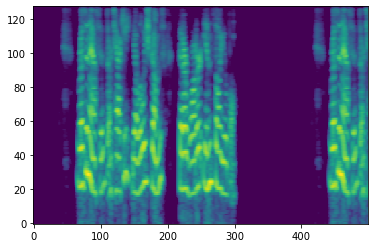

In [43]:
image = imageio.imread(selected_misclassified_file + '.png')
plt.imshow(image, origin='lower', aspect='auto')
plt.show()